# Simulation: The Brier score under administrative censoring

As discussed in the paper [LINK], under administrative censoring, the IPCW Brier score can be biased if the covariates contain information closely connected to some of the censoring times.
The proposed Administrative Brier score can be a useful alternative in these cases.

We here reproduce one of the simulations from Section [SOMETHING] to show a scenario where the IPCW Brier has a clear bias and fails to rank the performance of two methods correctly. While the administrative Brier score still works as expected.
The dataset `sac_admin5` contains the simulations, but is a little larger than the one in the paper.

We will compare the `LogisticHazard` method with the `BCESurv`, where the latter is essentially as set of binary classifiers that disregards individuals as they are censored.

**The following is not an introduction to the topic, so we recommend the reader to also look at the paper to understand the points made here.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
import torch
import torchtuples as tt
from pycox.datasets import sac_admin5
from pycox.models import LogisticHazard, BCESurv
from pycox.evaluation import EvalSurv

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [4]:
df_train = sac_admin5.read_df()
df_test = df_train.sample(frac=0.4)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=1/3)
df_train = df_train.drop(df_val.index)

In [5]:
tt.tuplefy(df_train, df_val, df_test).lens()

(20000, 10000, 20000)

## Feature transforms

The dataset has covariates: `x0, ..., x23`, and we will standardize all covariates.
Here we use the `sklearn_pandas.DataFrameMapper` to make feature mappers, but this has nothing to do the the `pycox` package.

In [6]:
def preprocess(df_train, df_val, df_test, n_durations=50):
    cols = list(df_train.columns.drop(['duration', 'event', 'duration_true', 'event_true', 'censoring_true']))

    x_mapper = DataFrameMapper([([col], StandardScaler()) for col in cols])
    x_train = x_mapper.fit_transform(df_train).astype('float32')
    x_val = x_mapper.transform(df_val).astype('float32')
    x_test = x_mapper.transform(df_test).astype('float32')

    labtrans = LogisticHazard.label_transform(n_durations)
    get_dur_ev = lambda df: (df['duration'].values.astype('float32'), df['event'].values.astype('float32'))

    y_train = labtrans.fit_transform(*get_dur_ev(df_train))
    y_val = labtrans.transform(*get_dur_ev(df_val))
    y_test = labtrans.transform(*get_dur_ev(df_test))

    train = tt.tuplefy(x_train, y_train)
    val = tt.tuplefy(x_val, y_val)
    test = tt.tuplefy(x_test, y_test)
    return train, val, test, labtrans

We transform the covariates and targets so they can be used by the Logistic-Hazard and BCE method

In [7]:
%%time
train, val, test, labtrans = preprocess(df_train, df_val, df_test)

CPU times: user 217 ms, sys: 17.7 ms, total: 235 ms
Wall time: 277 ms


In [8]:
def make_net(train, labtrans, n_layers=4, n_nodes=32, dropout=0.1):
    in_features = train[0].shape[1]
    out_features = labtrans.out_features
    num_nodes = [n_nodes] * n_layers
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features,
                                  dropout=dropout)
    return net

In [9]:
def fit_and_predict(model_class, train, val, test, labtrans, lr=0.01, n_itp=20):
    net = make_net(train, labtrans)
    model = model_class(net, tt.optim.AdamWR(lr, cycle_eta_multiplier=0.8), duration_index=labtrans.cuts)
    log = model.fit(*train, 256, 128, verbose=False, val_data=val,
                    callbacks=[tt.cb.EarlyStoppingCycle()])
    surv = model.interpolate(n_itp).predict_surv_df(test[0])
    return surv, model

We fit a Logistic-Hazard to the data set, and make survival predictions

In [10]:
%%time
surv, model = fit_and_predict(LogisticHazard, train, val, test, labtrans, lr=0.01)

CPU times: user 3min 49s, sys: 8.04 s, total: 3min 57s
Wall time: 1min 33s


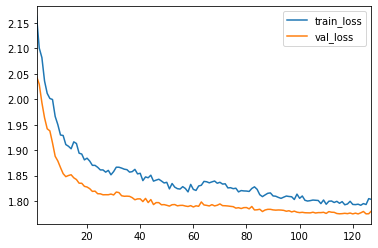

In [11]:
_ = model.log.to_pandas().iloc[1:].plot()

We fit the BCE method to the data set, and make survival predictions

In [12]:
%%time
surv_bce, model_bce = fit_and_predict(BCESurv, train, val, test, labtrans, lr=0.01)

CPU times: user 3min 32s, sys: 6.8 s, total: 3min 38s
Wall time: 1min 20s


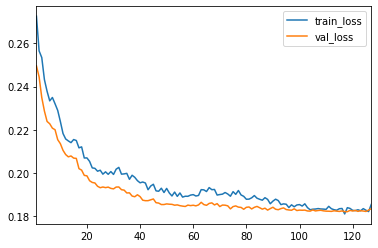

In [13]:
_ = model_bce.log.to_pandas().iloc[1:].plot()

## Evaluation

For evaluation we will compare scores on the full uncensored data set, with the IPCW Brier score and the administrative Brier score on a test set with the same censoring distribution as the training set.

In [14]:
durations = df_test['duration'].values
events = df_test['event'].values
durations_true = df_test['duration_true'].values
events_true = df_test['event_true'].values
censor_durations = df_test['censoring_true'].values

In [15]:
ev_true = EvalSurv(surv, durations_true, events_true, 'km')
ev_bce_true = EvalSurv(surv_bce, durations_true, events_true, 'km')

In [16]:
time_grid = np.linspace(0, 100, 100)

### Uncensored test set

For the uncensored test set, we see that the BCE method is clearly much worse then the Logistic-Hazard. This is expected as the BCE method simply disregards censored individuals.

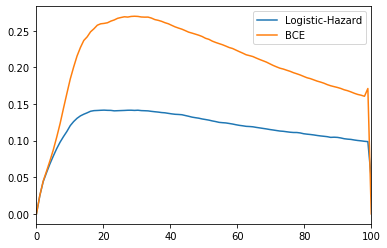

In [17]:
ev_true.brier_score(time_grid).rename('Logistic-Hazard').plot()
ev_bce_true.brier_score(time_grid).rename('BCE').plot()
_ = plt.legend()

In [18]:
ev_true.integrated_brier_score(time_grid), ev_bce_true.integrated_brier_score(time_grid)

(0.11843521411909225, 0.2087353025907521)

### IPCW Brier score with Kaplan-Meier censoring estimates

We see that the IPCW Brier score actually considers the BCE method better thn the Logistic-Hazard. We know from the uncensored test set that this is the wrong conclusion.

In [19]:
ev = EvalSurv(surv, durations, events, 'km', censor_durations)
ev_bce = EvalSurv(surv_bce, durations, events, 'km', censor_durations)

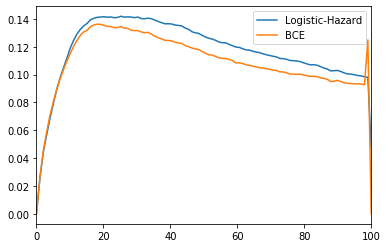

In [20]:
ev.brier_score(time_grid).rename('Logistic-Hazard').plot()
ev_bce.brier_score(time_grid).rename('BCE').plot()
_ = plt.legend()

In [21]:
ev.integrated_brier_score(time_grid), ev_bce.integrated_brier_score(time_grid)

(0.1174541826311283, 0.10952409721115865)

### The Administrative Brier Score

The administrative Brier score correctly finds that the estimates of the BCE method is works than those of the Logistic-Hazard.

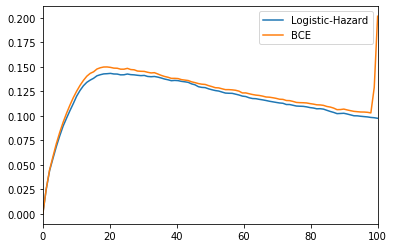

In [22]:
ev.brier_score_admin(time_grid).rename('Logistic-Hazard').plot()
ev_bce.brier_score_admin(time_grid).rename('BCE').plot()
_ = plt.legend()

In [23]:
ev.integrated_brier_score_admin(time_grid), ev_bce.integrated_brier_score_admin(time_grid)

(0.11781944742706693, 0.1225675342139344)

## Estimating the  censoring distribution

Instead of using Kaplan-Meier estimates of the censoring distribution in the IPCW Brier score, we can use a methods that allows for covariate-dependent estimation.

The censoring distribution is, in itself, a survival process, but with opposite labels of the regular survival process.
We can therefore estimate the censoring distribution with a survival model, but first we need to swap the labels.

In [24]:
censor_dfs = (tt.tuplefy(df_train, df_val, df_test)
              .apply(lambda x: x.assign(event=lambda s: 1 - s['event'])))

In [25]:
censor_dfs[0]['event'].values[:5]

array([1., 1., 1., 0., 1.], dtype=float32)

In [26]:
df_train['event'].values[:5]

array([0., 0., 0., 1., 0.], dtype=float32)

We use a Logistic-Hazard model for estimating the censoring distribution. It has the same configurations as the survival model.

In [27]:
%%time
censor_data = preprocess(*censor_dfs)
censor_surv, censor_model = fit_and_predict(LogisticHazard, *censor_data, lr=0.01)

CPU times: user 1min 51s, sys: 3.98 s, total: 1min 55s
Wall time: 46.2 s


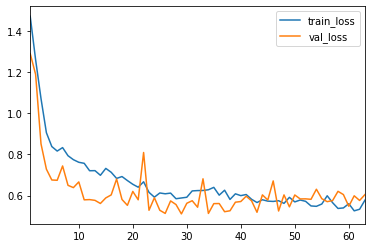

In [28]:
censor_model.log.to_pandas().iloc[1:].plot()

In [29]:
ev_cens = EvalSurv(surv, durations, events, censor_surv)
ev_bce_cens = EvalSurv(surv_bce, durations, events, censor_surv)

The IPCW Brier score with the new censoring estimates clearly considers the BCE methods better than the Logistic-Hazard survival model.
So, only the Administrative Brier scores was able to correctly rank the two methods.

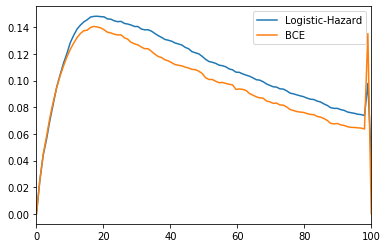

In [30]:
ev_cens.brier_score(time_grid).rename('Logistic-Hazard').plot()
ev_bce_cens.brier_score(time_grid).rename('BCE').plot()
_ = plt.legend()

In [31]:
ev_cens.integrated_brier_score(time_grid), ev_bce_cens.integrated_brier_score(time_grid)

(0.10889572553012469, 0.0985783516744046)

By further investigating the censoring estimates, we find that it has a very high concordance and a very small brier score.
This confirms that we are almost able to identify the censoring times, as discussed in the paper.

In [32]:
ev_cens.censor_surv.concordance_td(), ev_cens.censor_surv.add_km_censor().integrated_brier_score(time_grid)

(0.9881688231010213, 0.01184456795207496)

## Binomial log-likelihood

We find the same patterns for the (negative) binomial log-likelihood

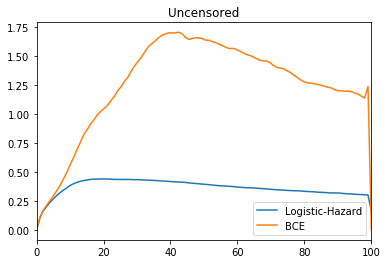

In [33]:
ev_true.nbll(time_grid).rename('Logistic-Hazard').plot()
ev_bce_true.nbll(time_grid).rename('BCE').plot()
plt.title('Uncensored')
_ = plt.legend()

In [34]:
ev_true.integrated_nbll(time_grid), ev_bce_true.integrated_nbll(time_grid)

(0.36522008829959496, 1.246794590234243)

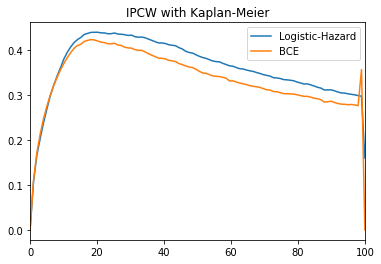

In [35]:
ev.nbll(time_grid).rename('Logistic-Hazard').plot()
ev_bce.nbll(time_grid).rename('BCE').plot()
plt.title('IPCW with Kaplan-Meier')
_ = plt.legend()

In [36]:
ev.integrated_nbll(time_grid), ev_bce.integrated_nbll(time_grid)

(0.36138029672004307, 0.3369783440979498)

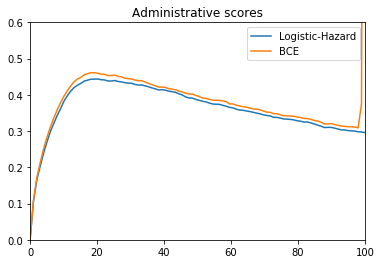

In [37]:
ev.nbll_admin(time_grid).rename('Logistic-Hazard').plot()
ev_bce.nbll_admin(time_grid).rename('BCE').plot()
plt.ylim(0, 0.6)
plt.title('Administrative scores')
_ = plt.legend()

In [38]:
ev.integrated_nbll_admin(time_grid), ev_bce.integrated_nbll_admin(time_grid)

(0.36220632960993066, 0.3855116022041178)

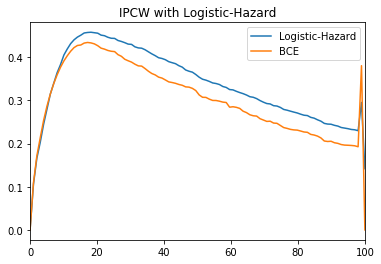

In [39]:
ev_cens.nbll(time_grid).rename('Logistic-Hazard').plot()
ev_bce_cens.nbll(time_grid).rename('BCE').plot()
plt.title('IPCW with Logistic-Hazard')
_ = plt.legend()

In [40]:
ev_cens.integrated_nbll(time_grid), ev_bce_cens.integrated_nbll(time_grid)

(0.33639969217229554, 0.3037243121488582)